# Network Robustness & Resilience Analysis

This notebook analyzes the robustness of the Helsinki City Bikes network. We simulate the removal of stations (nodes) to test how the network's connectivity degrades. We compare three strategies:
1. **Random Failure**: Removing nodes randomly.
2. **Targeted Attack (Degree)**: Removing highly connected hubs first.
3. **Targeted Attack (Betweenness)**: Removing critical "bridge" nodes first.

In [1]:
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from tqdm import tqdm

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

## 1. Data Loading & Graph Construction

In [2]:
# Load cleaned data
df = pd.read_csv('../data/2021-04_cleaned.csv', parse_dates=['Departure', 'Return'])

# Create Graph
G = nx.DiGraph()

# Add edges (weighted by trip count)
trips = df.groupby(['Departure station id', 'Return station id']).size().reset_index(name='weight')
for _, row in trips.iterrows():
    G.add_edge(row['Departure station id'], row['Return station id'], weight=row['weight'])

print(f"Nodes: {G.number_of_nodes()}")
print(f"Edges: {G.number_of_edges()}")

# Create an undirected version for Giant Component analysis (connectivity is usually undirected concept in robustness)
G_undirected = G.to_undirected()

Nodes: 351
Edges: 32815


## 2. Attack Simulation Functions

In [3]:
def get_giant_component_size(g):
    """Returns the fraction of nodes in the largest connected component."""
    if len(g) == 0:
        return 0
    components = sorted(nx.connected_components(g), key=len, reverse=True)
    if not components:
        return 0
    return len(components[0]) / initial_nodes

def simulate_attack(graph, strategy='random'):
    """
    Simulates node removal based on strategy.
    Returns list of (fraction_removed, giant_component_fraction)
    """
    g = graph.copy()
    results = [(0, 1.0)] # Initial state
    nodes_to_remove = []
    
    if strategy == 'random':
        nodes_to_remove = list(g.nodes())
        random.shuffle(nodes_to_remove)
        
    elif strategy == 'degree':
        # Sort by degree (descending)
        nodes_to_remove = sorted(g.nodes(), key=lambda n: g.degree(n), reverse=True)
        
    elif strategy == 'betweenness':
        # Recalculate betweenness? No, usually done on initial static structure for speed, 
        # or recalculated every step (adaptive). Adaptive is too slow for now, let's do static.
        bc = nx.betweenness_centrality(g)
        nodes_to_remove = sorted(g.nodes(), key=lambda n: bc[n], reverse=True)
        
    N = len(nodes_to_remove)
    
    for i, node in enumerate(tqdm(nodes_to_remove, desc=f"Simulating {strategy}")):
        g.remove_node(node)
        
        # Record state every few steps to speed up
        if i % 5 == 0 or i == N-1:
            f = (i + 1) / initial_nodes
            s = get_giant_component_size(g)
            results.append((f, s))
            
    return results

## 3. Run Simulations

In [4]:
initial_nodes = G_undirected.number_of_nodes()

# 1. Random Attack (Run multiple times to average?)
# For visual clarity, one run is often enough if N is large-ish, but let's do 10 runs for smooth random curve.
random_res_list = []
for _ in range(5):
    random_res_list.append(simulate_attack(G_undirected, 'random'))

# Average Random Results
# Interpolate to common x-axis
from scipy.interpolate import interp1d
x_common = np.linspace(0, 1, 100)
y_random_avg = np.zeros_like(x_common)

for res in random_res_list:
    x, y = zip(*res)
    f = interp1d(x, y, kind='linear', fill_value="extrapolate")
    y_random_avg += f(x_common)
y_random_avg /= len(random_res_list)

# 2. Degree Attack
degree_res = simulate_attack(G_undirected, 'degree')

# 3. Betweenness Attack
betweenness_res = simulate_attack(G_undirected, 'betweenness')

Simulating random:   0%|                               | 0/351 [00:00<?, ?it/s]

Simulating random: 100%|███████████████████| 351/351 [00:00<00:00, 5710.61it/s]

Simulating random:   0%|                               | 0/351 [00:00<?, ?it/s]

Simulating random: 100%|███████████████████| 351/351 [00:00<00:00, 4312.20it/s]

Simulating random:   0%|                               | 0/351 [00:00<?, ?it/s]

Simulating random: 100%|███████████████████| 351/351 [00:00<00:00, 7410.02it/s]

Simulating random:   0%|                               | 0/351 [00:00<?, ?it/s]

Simulating random: 100%|███████████████████| 351/351 [00:00<00:00, 9120.59it/s]

Simulating random:   0%|                               | 0/351 [00:00<?, ?it/s]

Simulating random: 100%|███████████████████| 351/351 [00:00<00:00, 9407.63it/s]

Simulating degree:   0%|                               | 0/351 [00:00<?, ?it/s]

Simulating degree: 100%|██████████████████| 351/351 [00:00<00:00, 13263.07it/s]

Simulating betweenness:   0%|                          | 0/351 [00:00<?, ?it/s]

Simulating betweenness: 100%|█████████████| 351/351 [00:00<00:00, 13329.24it/s]

## 4. Visualization

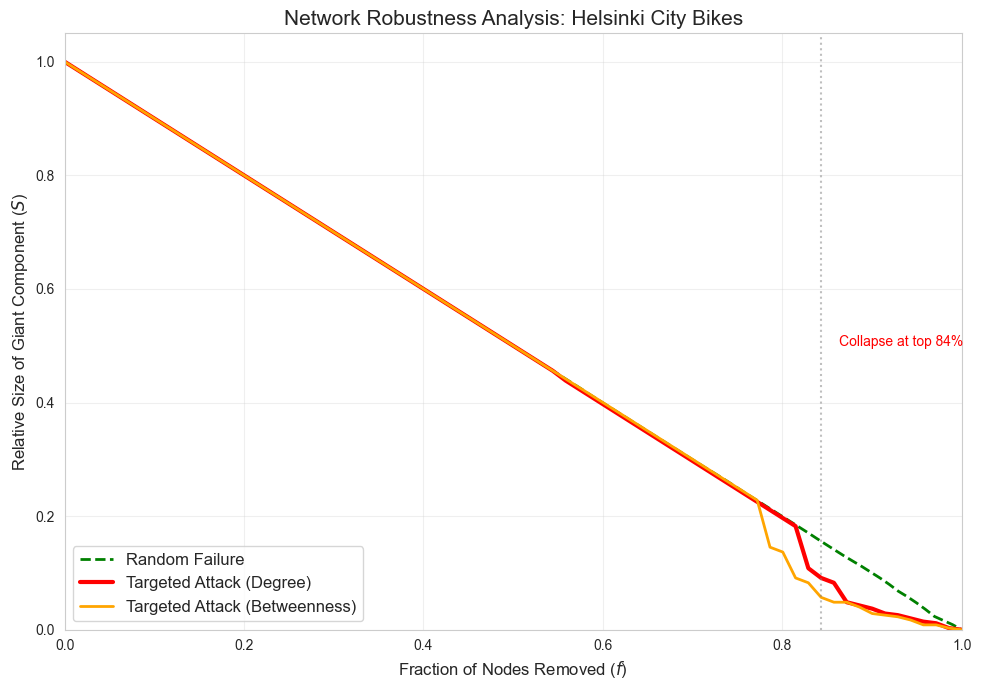

In [5]:
plt.figure(figsize=(10, 7))

# Plot Random
plt.plot(x_common, y_random_avg, label='Random Failure', color='green', linewidth=2, linestyle='--')

# Plot Targeted
x_deg, y_deg = zip(*degree_res)
plt.plot(x_deg, y_deg, label='Targeted Attack (Degree)', color='red', linewidth=3)

x_bet, y_bet = zip(*betweenness_res)
plt.plot(x_bet, y_bet, label='Targeted Attack (Betweenness)', color='orange', linewidth=2)

# Aesthetics
plt.title('Network Robustness Analysis: Helsinki City Bikes', fontsize=15)
plt.xlabel('Fraction of Nodes Removed ($f$)', fontsize=12)
plt.ylabel('Relative Size of Giant Component ($S$)', fontsize=12)
plt.legend(fontsize=12)
plt.xlim(0, 1)
plt.ylim(0, 1.05)
plt.grid(True, alpha=0.3)

# Add annotation for breakpoint
# Find where degree attack drops below 0.1
for i, val in enumerate(y_deg):
    if val < 0.1:
        plt.axvline(x_deg[i], color='gray', linestyle=':', alpha=0.5)
        plt.text(x_deg[i]+0.02, 0.5, f'Collapse at top {x_deg[i]*100:.0f}%', color='red')
        break

plt.tight_layout()
plt.savefig('../data/robustness_comparison.png', dpi=300, bbox_inches='tight')
plt.show()